# Theory

In this notebook, we will model COVID-19 dynamics with the SIR model. It segments the population into three compartments:
1. Susceptible: # people vulnerable to exposure with the infectious
2. Infectious: # people who can spread the disease
3. Recovered: # people who were infected and is now healed with immunity.

The SIR model is described by the ODE

$$\begin{split} \dot{S}  & = - \beta I S \\
\dot{I} & = \beta I S - \gamma I \\
\dot{R} & = \gamma I
\end{split}$$

Remark: the outstanding period of the disease is assumed to be much shorter than the lifetime of human (hence natural deaths/births are not considered). The two parameters $\beta$ (how much the disease can be transmitted through exposure) and $\gamma$ (how much the disease can be recovered) can be used to derive the **average days to recover from the disease** as 

$$ D = \frac{1}{\gamma} $$

and the **basic reproduction number** (the average number of people than a sick person can infect)

$$ R_0 = \frac{\beta}{\gamma} $$

For more details, see https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology

## Controlling a pandemic

Naturally, the higher $R_0$ is, the higher number of people with immunity is required to avoid a pandemic. We define the **balanced state** as follows: If the proportion of people with immunity is $p$, the basic reproduction number multiplied by the proportion of people without immunity is one

$$ R_0 (1-p) = 1 $$

leading to $p_c = 1 - \frac{1}{R_0}$ as the minimum **Herd Immune Threshold** to stop a pandemic. HIT can be increased, for example, by vaccination.

## Visualizations

* https://meltingasphalt.com/interactive/outbreak/

In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import scipy
import matplotlib.pyplot as plt

In [2]:
def f(x, t, beta, gamma, population):
    """
    The system of ODEs for the SIR model
    
    Args:
    x -- a list consisting of S, I, and R in order
    """
    r1 = -beta * x[0] * x[1] / population
    r2 = beta * x[0] * x[1] / population - gamma * x[1]
    r3 = gamma * x[1]
    return [r1, r2, r3]

In [4]:
# data is from Kaggle COVID-19 Forecasting Challenge
# which is curated from John Hopkins CSSE
# https://github.com/CSSEGISandData/COVID-19

pop_italy = 60486683.
pop_spain = 46749696.
pop_UK = 67784927.
pop_singapore = 5837230.

train_data = pd.read_csv("data/train.csv")

display(train_data)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0
...,...,...,...,...,...,...
22333,32704,NaN,Zimbabwe,2020-03-30,7.0,1.0
22334,32705,NaN,Zimbabwe,2020-03-31,8.0,1.0
22335,32706,NaN,Zimbabwe,2020-04-01,8.0,1.0
22336,32707,NaN,Zimbabwe,2020-04-02,9.0,1.0


In [9]:
# first we prepare the data into a form that is suitable for analysis
country = 'Italy'
population = pop_italy

country_df = train_data.copy()
country_df = country_df.loc[country_df['Country_Region']==country]
country_df['ConfirmedDiff'] = country_df.ConfirmedCases.diff().fillna(0) # need daily cases instead of cumulative cases

first_occurence = country_df.ConfirmedCases.to_numpy().nonzero()[0][0]

# now we need the day count since the first occurence
country_df = country_df[first_occurence:]
country_df['day_count'] = list(range(1,len(country_df)+1))

ydata = [i for i in country_df.ConfirmedCases] #infected cases
xdata = country_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

# initial conditions
# we start with 0 recovered case
x0 = [population - ydata[0], ydata[0], 0.]

# testing to see if you get it right
temp = odeint(f, x0, xdata, args=(0.3, 0.5, population))
temp[:,1] # the infected cases


array([2.00000000e+00, 1.63746148e+00, 1.34064006e+00, 1.09762322e+00,
       8.98657870e-01, 7.35758815e-01, 6.02388350e-01, 4.93193853e-01,
       4.03792962e-01, 3.30597703e-01, 2.70670506e-01, 2.21606266e-01,
       1.81435862e-01, 1.48547116e-01, 1.21620090e-01, 9.95741067e-02,
       8.15243833e-02, 6.67465191e-02, 5.46474276e-02, 4.47415291e-02,
       3.66312656e-02, 2.99911433e-02, 2.45546711e-02, 2.01036648e-02,
       1.64594884e-02, 1.34758894e-02, 1.10331251e-02, 9.03315871e-03,
       7.39572490e-03, 6.05510737e-03, 4.95750261e-03, 4.05885986e-03,
       3.32311335e-03, 2.72073511e-03, 2.22755000e-03, 1.82376357e-03,
       1.49317065e-03, 1.22250419e-03, 1.00090148e-03, 8.19468551e-04,
       6.70923864e-04, 5.49305845e-04, 4.49733140e-04, 3.68210251e-04,
       3.01465040e-04, 2.46818601e-04, 2.02077831e-04, 1.65447314e-04,
       1.35456782e-04, 1.10902593e-04, 9.07993055e-05, 7.43396752e-05,
       6.08644355e-05, 4.98322094e-05, 4.07999414e-05, 3.34042062e-05,
      

In [10]:
# fit the parameters beta and gamma from data
# using least squares fit
p_opt, p_cov = scipy.optimize.curve_fit(lambda t, beta, gamma: odeint(f, x0, t, args=(beta, gamma,population))[:,1], xdata, ydata)
p_opt

/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/Users/kevinsiswandi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


array([3.4124434 , 3.20723383])

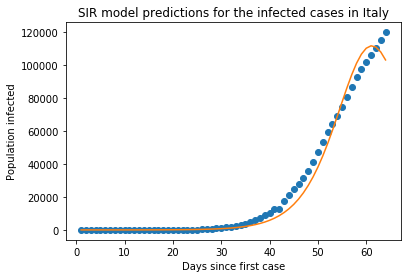

Fitted parameters: beta = 3.4124434020529657  and gamma =  3.2072338281630586


In [11]:
pred_data = odeint(f, x0, xdata, args=(p_opt[0], p_opt[1],population))[:,1]

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, pred_data)
plt.title("SIR model predictions for the infected cases in " + country)
plt.ylabel("Population infected")
plt.xlabel("Days since first case")
plt.show()
print("Fitted parameters: beta =", p_opt[0], " and gamma = ", p_opt[1])

In [12]:
print("Average day to recover from disease in ", country, " is ", 1/p_opt[1])
print("Basic reproduction number in ", country, " is ", p_opt[0]/p_opt[1])

Average day to recover from disease in  Italy  is  0.3117951647986793
Basic reproduction number in  Italy  is  1.0639833529092704
